In [52]:
# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from pyjet import cluster


from rikabplotlib.plot_utils import newplot, hist_with_outline, hist_with_errors

In [53]:
N_jets = 25000
R = 0.5
X, y = qg_jets.load(N_jets)

# Jet only jets with y = 1
X = X[y == 1][:N_jets]

# Preprocess
X = X[:,:,:3]
total_energy = np.sum(X[:,:,0], axis=1)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()



angularity = np.sum(X[:,:,0] * np.sqrt(X[:,:,1]**2 + X[:,:,2]**2) , axis=1)

def compute_angularity(events, axis = None):


    if axis is None:
        return np.sum(events[:,:,0] * np.sqrt(events[:,:,1]**2 + events[:,:,2]**2) , axis=1)
    else:
        return np.sum(events[:,:,0] * np.sqrt((events[:,:,1] - axis[:,None,1])**2 + (events[:,:,2] - axis[:,None,2])**2) , axis=1)



def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))


def LO(x, E = 500):

    scale = E * x
    return 1 * alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x

def LL(x, E = 500):
    scale = E * x


    exp = np.exp(- np.log(x )**2 * alpha_s(scale) * 4 / 3 / 2 / np.pi)
    return  alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x * exp

In [54]:
def kT_N(events, N, R, d_ij_cut = None):

    jets = []

    for event in events:

        # Set up 4-vectors
        four_vectors = []
        for particle in event:

            # Important that this is a list () and not a tuple []
            four_vectors.append((particle[0], particle[1], particle[2], 0))
            
        four_vectors = np.array(four_vectors, dtype=[("pt", "f8"), ("eta", "f8"), ("phi", "f8"), ("mass", "f8")])

        # Cluster with kT (p = 1)

        sequence = cluster(four_vectors, R=R, p=1, recomb_scheme = "WTA_pt_scheme")
        if d_ij_cut is None:
            subjets = sequence.exclusive_jets(N)
        else:
            subjets = sequence.exclusive_jets_dcut(d_ij_cut)

        output = np.zeros((N, 3))
        for i, subjet in enumerate(subjets[:N]):
            output[i,0] = subjet.pt
            output[i,1] = subjet.eta
            output[i,2] = subjet.phi


        # Normalize
        output[:,0] = np.nan_to_num(output[:,0] / np.sum(output[:,0]))

        jets.append(output)


    return np.array(jets)


def get_WTA_axis(events):

    return kT_N(events, 1, R)[:,0]

[[ 1.00000000e+00 -2.52514112e-03  5.11039679e-04]
 [ 1.00000000e+00  4.88926903e-04 -1.91566644e-03]
 [ 1.00000000e+00 -7.24154208e-03  6.85391599e-02]
 ...
 [ 1.00000000e+00  7.54576846e-04  3.43679009e-04]
 [ 1.00000000e+00  1.76927321e-03  4.25970256e-03]
 [ 1.00000000e+00 -4.06519643e-02  1.76550643e-02]]
[[ 9.70521239e-01 -2.52514112e-03  5.11039679e-04]
 [ 2.94787610e-02  7.43042418e-02  1.56232675e-02]]
[0.64164888 0.24011591 0.6801042  ... 0.17578418 0.32734425 0.49587709]
[0.02947876 0.15794928 0.18047192 ... 0.18960416 0.30836664 0.202729  ]


/tmp/ipykernel_5489/1940908107.py:46: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(- np.log(x )**2 * alpha_s(scale) * 4 / 3 / 2 / np.pi)
/tmp/ipykernel_5489/1940908107.py:34: RuntimeWarning: divide by zero encountered in log
  return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))
/tmp/ipykernel_5489/1940908107.py:46: RuntimeWarning: invalid value encountered in multiply
  exp = np.exp(- np.log(x )**2 * alpha_s(scale) * 4 / 3 / 2 / np.pi)
/tmp/ipykernel_5489/1940908107.py:47: RuntimeWarning: divide by zero encountered in true_divide
  return  alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x * exp
/tmp/ipykernel_5489/1940908107.py:47: RuntimeWarning: invalid value encountered in multiply
  return  alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x * exp
/tmp/ipykernel_5489/1940908107.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 1 * alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x
/tmp/ipykernel_5489/1940908107.py:40: RuntimeWarning: inval

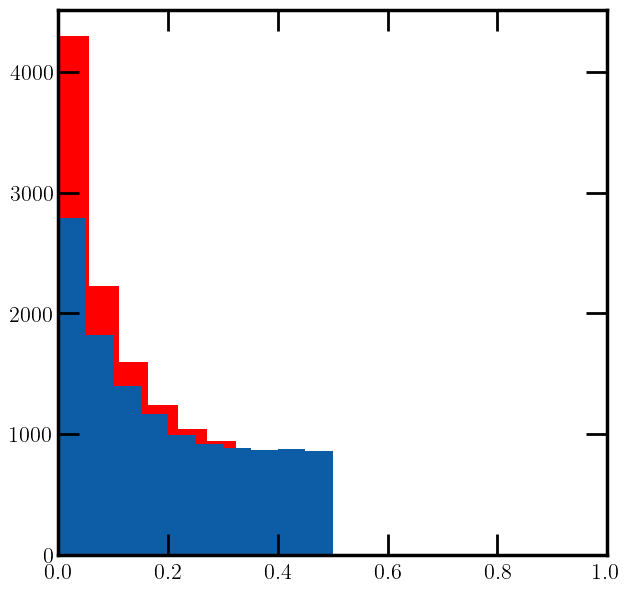

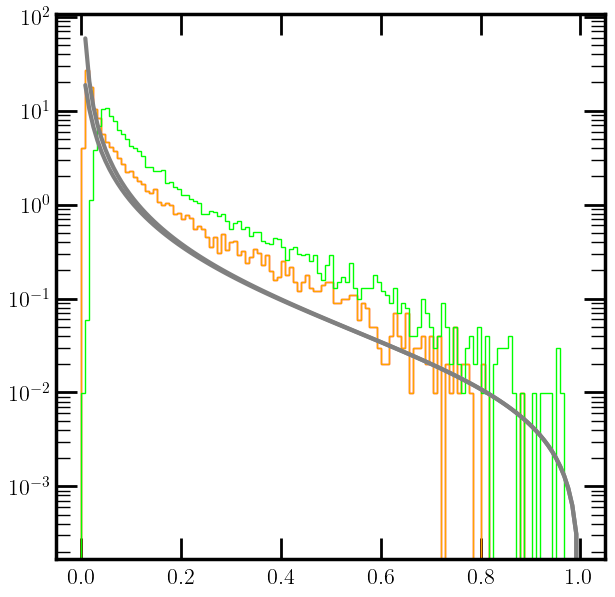

In [55]:
# Cluster until there are 2 subjets

two_subjets = kT_N(events = X, N=2, R=R)

two_subjet_angularities = compute_angularity(two_subjets, get_WTA_axis(two_subjets))

def deltaR(events):

    deltaRs = []

    for event in events:

        y1, phi1 = event[0,1], event[0,2]
        y2, phi2 = event[1,1], event[1,2]

        deltaRs.append(np.sqrt((y1-y2)**2 + (phi1-phi2)**2))

    return np.array(deltaRs)

def WTA_angularity(events):

    deltaRs = deltaR(events)
    softer_particle = events[:,1,0]
    return (deltaRs * softer_particle)

axes = get_WTA_axis(X)
print(axes)

two_subjet_WTA = WTA_angularity(two_subjets)
WTA_angularities = compute_angularity(X, axes)

print(two_subjets[0])
print(deltaR(X))
print(two_subjets[:,1,0])

fig, ax = newplot("full")
ax.hist(deltaR(two_subjets), color = "red")
ax.hist(two_subjets[:,1,0])
plt.xlim(0, 1)

# Plot
fig, ax = newplot("full")

ax.hist(4 * two_subjet_angularities, range = (0,1), bins = 125, density = True ,color="red", histtype = "step")
ax.hist(4 * two_subjet_WTA, range = (0,1), bins = 125, density = True ,color="orange", histtype = "step")
ax.hist(4 * WTA_angularities, range = (0,1), bins = 125, density = True ,color="lime", histtype = "step")


x = np.linspace(0, 1, 125)
plt.plot(x, LL(x), label="LL", color="grey")
plt.plot(x, LO(x), label="LO", color="grey")

plt.yscale("log")


In [56]:

def plot_event(ax, event, R, filename=None, color="red", title="", show=True):


    pts, ys, phis =event[:,0], event[:, 1], event[:, 2]
    ax.scatter(ys, phis, marker='o', s=2 * pts * 500/np.sum(pts), color=color, lw=0, zorder=10, label="Event")

    # Legend
    # legend = plt.legend(loc=(0.1, 1.0), frameon=False, ncol=3, handletextpad=0)
    # legend.legendHandles[0]._sizes = [150]

    # plot settings
    plt.xlim(-R, R)
    plt.ylim(-R, R)
    plt.xlabel('Rapidity')
    plt.ylabel('Azimuthal Angle')
    plt.title(title)
    plt.xticks(np.linspace(-R, R, 5))
    plt.yticks(np.linspace(-R, R, 5))

    ax.set_aspect('equal')
  

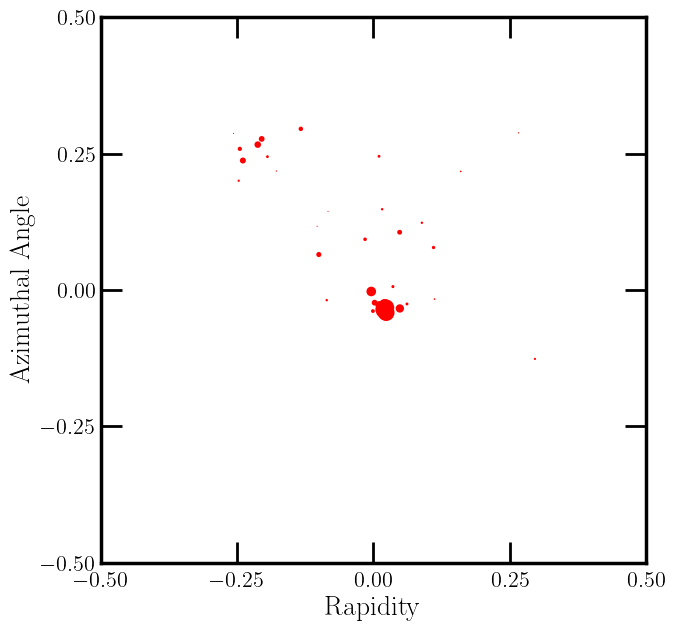

In [57]:
fig, ax = newplot("full")
plot_event(ax, X[3], R)

/tmp/ipykernel_5489/2184234631.py:32: RuntimeWarning: invalid value encountered in true_divide
  output[:,0] = np.nan_to_num(output[:,0] / np.sum(output[:,0]))


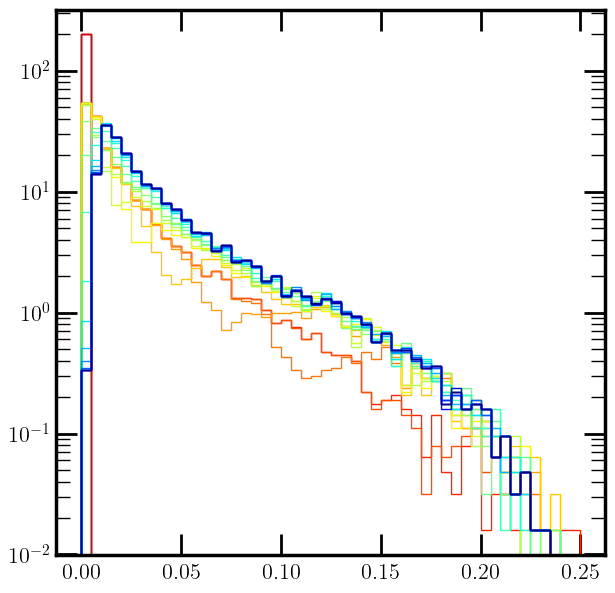

In [58]:



# Cluster the jet
d_ij_cuts = np.logspace(-10, 1, 24)[::-1]
colors = plt.cm.jet(np.linspace(0, 1, len(d_ij_cuts)))[::-1]
# fig, ax = newplot("full")
id = 2
# plot_event(ax, X[id], R, color = "black", title="Full Event")


# for (i,d_ij_cut) in enumerate(d_ij_cuts):

#     jets = kT_N(X, 100, R, d_ij_cut=d_ij_cut)

#     # plot_event(ax, X[0], R, title="d_ij_cut = {}".format(d_ij_cut))
#     plot_event(ax, jets[id], R, color=colors[i])
#     # plt.show()

#     # # Calculate the angularity
#     # angularity_jet = np.sum(jets[:,:,0] * np.sqrt(jets[:,:,1]**2 + jets[:,:,2]**2) , axis=1)

#     # fig, ax = newplot()
#     # hist_with_outline(ax, angularity_jet, bins=100, range=(0, 0.5), label="Jet")
#     # hist_with_outline(ax, angularity, bins=100, range=(0, 0.5), label="Particle")
#     # plt.show()

fig, ax = newplot("full")
    
for (i,d_ij_cut) in enumerate(d_ij_cuts):

    jets = kT_N(X, 100, R, d_ij_cut=d_ij_cut)
    np.save("Data/jets_dijcut_{}.npy".format(d_ij_cut), jets)
    

    # plot_event(ax, X[0], R, title="d_ij_cut = {}".format(d_ij_cut))
    ang = compute_angularity(jets)
    
    ax.hist(ang, bins = 50, range = [0, 0.25], density = True, color = colors[i], histtype="step")
    # plt.show()

    # # Calculate the angularity
    # angularity_jet = np.sum(jets[:,:,0] * np.sqrt(jets[:,:,1]**2 + jets[:,:,2]**2) , axis=1)

    # fig, ax = newplot()
    # hist_with_outline(ax, angularity_jet, bins=100, range=(0, 0.5), label="Jet")
    # hist_with_outline(ax, angularity, bins=100, range=(0, 0.5), label="Particle")
    # plt.show()

ax.set_yscale("log")

/tmp/ipykernel_5489/1940908107.py:46: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(- np.log(x )**2 * alpha_s(scale) * 4 / 3 / 2 / np.pi)
/tmp/ipykernel_5489/1940908107.py:34: RuntimeWarning: divide by zero encountered in log
  return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))
/tmp/ipykernel_5489/1940908107.py:46: RuntimeWarning: invalid value encountered in multiply
  exp = np.exp(- np.log(x )**2 * alpha_s(scale) * 4 / 3 / 2 / np.pi)
/tmp/ipykernel_5489/1940908107.py:47: RuntimeWarning: divide by zero encountered in true_divide
  return  alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x * exp
/tmp/ipykernel_5489/1940908107.py:47: RuntimeWarning: invalid value encountered in multiply
  return  alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x * exp
/tmp/ipykernel_5489/1940908107.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 1 * alpha_s(scale) * 4/3 / np.pi * np.log(1/x) / x
/tmp/ipykernel_5489/1940908107.py:40: RuntimeWarning: inval

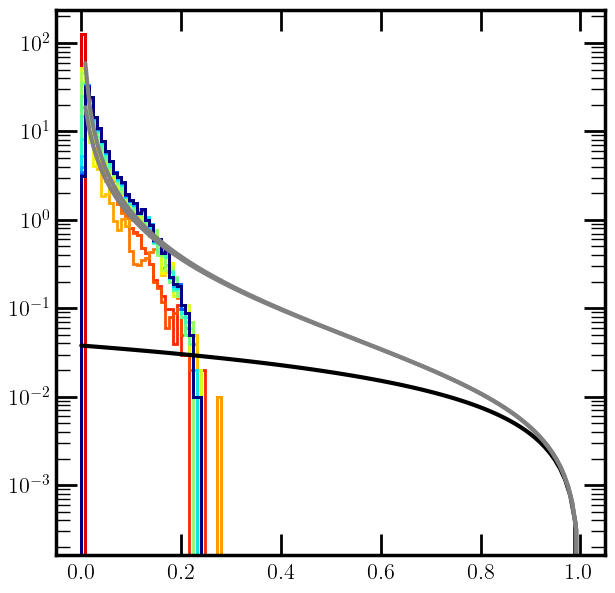

In [59]:
fig, ax = newplot("full")




    
for (i,d_ij_cut) in enumerate(d_ij_cuts):

    jets = np.load("Data/jets_dijcut_{}.npy".format(d_ij_cut))
    

    # plot_event(ax, X[0], R, title="d_ij_cut = {}".format(d_ij_cut))
    ang = compute_angularity(jets)
    
    ax.hist(ang, bins = 125, range = [0, 1], density = True, color = colors[i], histtype="step", lw = 2)
    # plt.show()

    # # Calculate the angularity
    # angularity_jet = np.sum(jets[:,:,0] * np.sqrt(jets[:,:,1]**2 + jets[:,:,2]**2) , axis=1)

    # fig, ax = newplot()
    # hist_with_outline(ax, angularity_jet, bins=100, range=(0, 0.5), label="Jet")
    # hist_with_outline(ax, angularity, bins=100, range=(0, 0.5), label="Particle")
    # plt.show()

ax.set_yscale("log")

# function to plot a line with a given slope and known point
def plot_line(ax, slope, point, **kwargs):
    x = np.linspace(0, 1, 100)
    y = slope * (x - point[0]) + point[1]
    ax.plot(x, y, **kwargs)

C_F = 4/3

plot_line(ax, -alpha_s(500) * C_F / (1* np.pi), (1, 0), label=r"$\alpha_s C_F / 2 \pi$", color="black")


x = np.linspace(0, 1, 125)
plt.plot(x, LL(x), label="LL", color="grey")
plt.plot(x, LO(x), label="LO", color="grey")